In [1]:
from sys import call_tracing
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA, FactorAnalysis, FastICA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import MDS, SpectralEmbedding, TSNE, Isomap
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.cluster import OPTICS, DBSCAN, KMeans
from sklearn.metrics import pairwise_distances
import umap
import mpl_toolkits.mplot3d.axes3d as p3
import os

In [2]:
win_size = 10
use_log = True
use_std = True
# ignore the first day
ignored = 1440

# group_func = 'mean'
group_func = 'mean_and_median'

# umap n_neighbors argument
nn = 50

reducers = {
    'pca': PCA(n_components=3),
    # 'umap': umap.UMAP(n_components=3, metric='cosine', n_neighbors=5, random_state=5566),
    'umap': umap.UMAP(n_components=3, metric='cosine', n_neighbors=nn, random_state=5566),
    # 'umap': umap.UMAP(n_components=3, n_neighbors=15, random_state=5566),
}
# reducer_name = 'pca'
reducer_name = 'umap'
reducer = reducers[reducer_name]
# custom_profile = 'nocustom'
custom_profile = 'cosine-nn%d' % nn
profile = '_'.join([reducer_name, 'log' if use_log else 'nolog', group_func, 'std' if use_std else 'nostd', 'ignore%d' % ignored, custom_profile])
print(profile)

umap_log_mean_and_median_std_ignore1440_cosine-nn50


In [3]:
conv_size = 3
txts = [f for f in os.listdir('./aligned') if f.endswith('.txt')]
monitor_cleaned_smooths = []
act_digests = []
act_origs = []
metas = []

one_meta2_test = pd.read_csv('./meta/one_meta2_test.csv', sep='\t')
# txt = txts[0]
for txt in txts:

    # try:
    #     meta = pd.read_csv('./meta/%s' % txt, sep='\t')
    # except:
    #     continue

    meta = one_meta2_test[one_meta2_test.File_Name == os.path.splitext(txt)[0]]
    #meta = one_meta[one_meta.File_Name == 'sdfghjkl;']
    if len(meta) == 0:
        print(txt)
        continue

    monitor = pd.read_csv('./aligned/%s' % txt, sep='\t', header=None)
    monitor = monitor.rename({1:'date', 2:'time'}, axis=1)
    monitor_cleaned = pd.concat([monitor.iloc[:,1:3], monitor.iloc[:,10:]], axis=1)
    monitor_cleaned = monitor_cleaned.iloc[ignored:,:]
    
    #### light dark filter implementation
    #hms = np.array([t.replace(' ', ':').split(':') for t in monitor_cleaned.time], dtype=int)
    #monitor_cleaned['h'] = hms[:,0]
    
    # light
    #monitor_cleaned = monitor_cleaned[(monitor_cleaned.h >= 5) & (monitor_cleaned.h <= 19)].iloc[:,:-1]
    
    # dark 
    #monitor_cleaned = monitor_cleaned[(monitor_cleaned.h <= 5) | (monitor_cleaned.h >= 19)].iloc[:,:-1]
    ####
    
    # monitor_cleaned_smooth = monitor_cleaned.iloc[:,2:].apply(np.convolve, v=np.array([1,1,1,1,1]), mode='valid')
    monitor_cleaned_smooth = monitor_cleaned.iloc[:,2:].apply(np.convolve, v=np.ones(conv_size), mode='valid')
    
    if use_log:
        monitor_cleaned_smooth = np.log(monitor_cleaned_smooth + 1)

    monitor_cleaned_smooth = pd.concat([monitor_cleaned.iloc[(conv_size-1):,:2].reset_index(drop=True), monitor_cleaned_smooth], axis=1)

    hms = np.array([t.replace(' ', ':').split(':') for t in monitor_cleaned_smooth.time], dtype=int)
    monitor_cleaned_smooth['h'] = hms[:,0]
    monitor_cleaned_smooth['mNcell'] = hms[:,1] // win_size
    #monitor_cleaned_smooth = monitor_cleaned_smooth[monitor_cleaned_smooth.h.isin([18,19,20,21,22,23,0,1,2,3,4,5])]
    #monitor_cleaned_smooth['m'] = hms[:,1]
    
    if group_func == 'mean':
        act_digest = pd.concat([monitor_cleaned_smooth.groupby(['h', 'mNcell']).mean().T, monitor_cleaned_smooth.groupby(['h', 'mNcell']).std().T], axis=1)
    else:
        # act_digest = pd.concat([monitor_cleaned_smooth.groupby(['h', 'mNcell']).median().T, monitor_cleaned_smooth.groupby(['h', 'mNcell']).std().T], axis=1)
        q1 = monitor_cleaned_smooth.groupby(['h', 'mNcell']).apply(pd.DataFrame.quantile, q=.25).T.iloc[:-2]
        q3 = monitor_cleaned_smooth.groupby(['h', 'mNcell']).apply(pd.DataFrame.quantile, q=.75).T.iloc[:-2]

        monitor_cleaned_smooth_min = monitor_cleaned_smooth.groupby(['h', 'mNcell']).min().T.iloc[2:]
        monitor_cleaned_smooth_max = monitor_cleaned_smooth.groupby(['h', 'mNcell']).max().T.iloc[2:]
        IQR = q3 - q1
        monitor_cleaned_smooth_whisker_min = q1 - 1.5 * IQR
        monitor_cleaned_smooth_whisker_max = q3 + 1.5 * IQR
        
        whisker_min_oob = (monitor_cleaned_smooth_whisker_min < monitor_cleaned_smooth_min)
        whisker_max_oob = (monitor_cleaned_smooth_whisker_max > monitor_cleaned_smooth_max)
        monitor_cleaned_smooth_whisker_min[whisker_min_oob] = monitor_cleaned_smooth_min[whisker_min_oob]
        monitor_cleaned_smooth_whisker_max[whisker_max_oob] = monitor_cleaned_smooth_max[whisker_max_oob]
        
        act_digest = pd.concat([
            monitor_cleaned_smooth.groupby(['h', 'mNcell']).mean().T, 
            monitor_cleaned_smooth.groupby(['h', 'mNcell']).std().T,
            monitor_cleaned_smooth.groupby(['h', 'mNcell']).median().T, 
            q1,
            q3,
            monitor_cleaned_smooth_whisker_min,
            monitor_cleaned_smooth_whisker_max,
            ], axis=1)
    
    act_orig = monitor_cleaned_smooth.iloc[:,2:34].T
    #act_digest = monitor_cleaned_smooth.groupby(['h', 'mNcell']).mean().T / monitor_cleaned_smooth.groupby(['h', 'mNcell']).std().T
    #act_digest = monitor_cleaned_smooth.groupby(['h', 'mNcell']).mean().T
    act_digests.append(act_digest)
    act_origs.append(act_orig)

    metas.append(meta)
    monitor_cleaned_smooths.append(monitor_cleaned_smooth)

meta_union = pd.concat(metas).reset_index(drop=True)
np.sum(meta_union.Instar.isna())
act_digests_npy = np.concatenate(act_digests)
act_origs_npy = np.concatenate(act_origs)
monitor_cleaned_smooths_union = pd.concat(monitor_cleaned_smooths).reset_index(drop=True)

In [4]:
meta_union.shape

(512, 28)

### filter MF & WL

In [5]:
filter_source = (meta_union['Source'] == 'MF') | (meta_union['Source'] == 'WL')

In [6]:
# only select rows where Source = X
# df.loc[df['column_name'] == some_value]
meta_filter = meta_union[filter_source]
#meta_union[filter_source].iloc[:40]

In [9]:
act_filter = act_digests_npy[filter_source]
act_filter.shape

(170, 1008)

In [10]:
# 3D scatter plot
def scatter3d(data3d, color_map=None, azimuth=-74, elevation=54, figsize=(10, 10)):

    fig = plt.figure(figsize=figsize)
    ax = p3.Axes3D(fig)
    ax.view_init(elevation, azimuth)

    if color_map is None:
        ax.scatter(data3d[:,0], data3d[:,1], data3d[:,2],
                    s=30, edgecolor='k')
    else:
        ax.scatter(data3d[:,0], data3d[:,1], data3d[:,2],
                    color=plt.cm.jet(color_map),
                    s=30, edgecolor='k')
    return ax

def stdscaler (X, use_std=True):
    if use_std:
        return StandardScaler().fit_transform(X)
    else:
        return X

In [13]:
reducer = umap.UMAP(n_components=3, metric='cosine', n_neighbors=15, random_state=5566)
#reducer = PCA(n_components=3, random_state=5566)

# try:
#     pwdists = pairwise_distances(dr)
# except:
#act_digests_npy = np.concatenate(act_digests)
#act_digests_npy_transformed = stdscaler(act_digests_npy, use_std)
#dr = reducer.fit_transform(act_digests_npy_transformed)

act_filter_transformed = stdscaler(act_filter, use_std)
dr = reducer.fit_transform(act_filter_transformed)
act_filter_transformed.shape
dr.shape
# reducer.fit(act_digests_npy_transformed)
# reducer.transform(act_digests_npy_transformed)
pwdists = pairwise_distances(dr)

pwdists.shape

(170, 170)

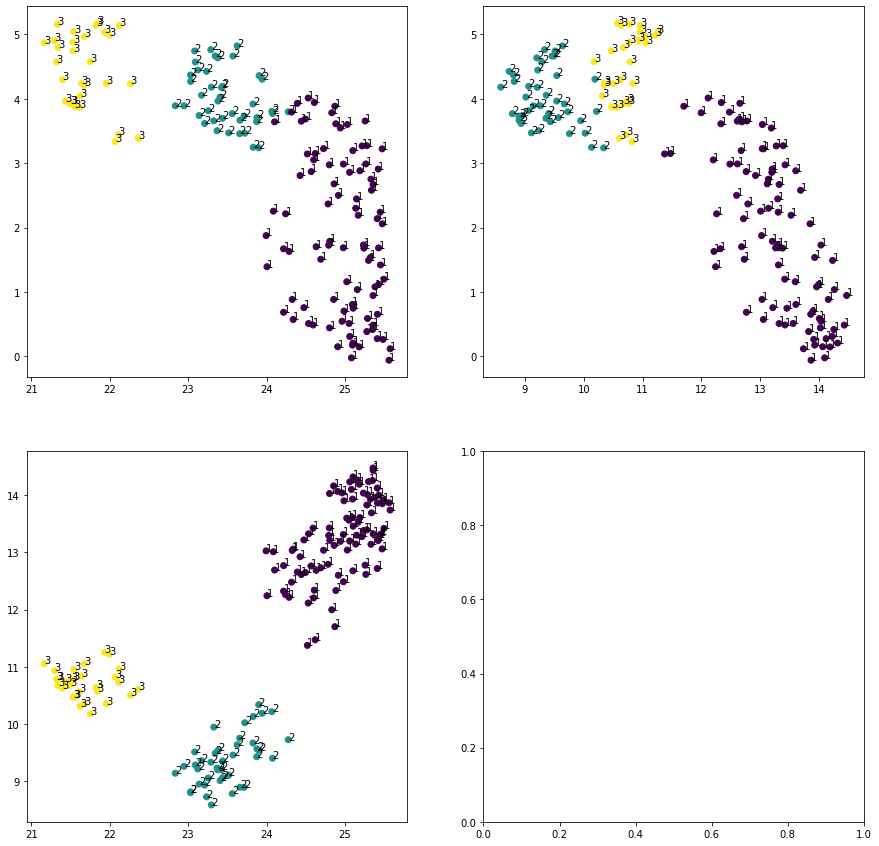

In [14]:
min_samples = 20

shortest_dists_mean = np.take_along_axis(pwdists, np.argsort(pwdists)[:,1:(1+min_samples)], axis=1).mean(axis=1)
shortest_dists_mean_std = shortest_dists_mean.std()
eps = shortest_dists_mean.mean() + 2 * shortest_dists_mean_std

clusterer = DBSCAN(eps=eps, min_samples=min_samples)
group_idxs_ = clusterer.fit_predict(dr) + 1
group_idxs = group_idxs_[group_idxs_ > 0]
dr_wg = dr[group_idxs_ > 0]
gcolor_map = group_idxs / (group_idxs.max() + 1)

fig, axs = plt.subplots(2, 2, figsize=(15, 15))
axs[0][0].scatter(dr_wg[:,0], dr_wg[:,1], c=gcolor_map)
axs[0][1].scatter(dr_wg[:,2], dr_wg[:,1], c=gcolor_map)
axs[1][0].scatter(dr_wg[:,0], dr_wg[:,2], c=gcolor_map)
for tid in range(dr_wg.shape[0]):
    axs[0][0].text(dr_wg[tid,0], dr_wg[tid,1], group_idxs[tid])
    axs[0][1].text(dr_wg[tid,2], dr_wg[tid,1], group_idxs[tid])
    axs[1][0].text(dr_wg[tid,0], dr_wg[tid,2], group_idxs[tid])
plt.show()

In [22]:
# adding a group column, organizing the scatterplot group 1,2 into data table
meta_filter_with_group = meta_filter.copy()
meta_filter_with_group['group'] = group_idxs_
meta_filter_with_group[group_idxs_ == 2].iloc[:40]
# meta_filter_with_group[group_idxs_ == 0] 
# 2 WL indivs belong to group 0 (outliers)

,ExpID,File_Name,Env,Setup,LD_cycle,Num,ID,Nest,Source,Location,...,End_Date,Soil,Bury,Eggs,Instar,Distance,Carcass,Phenotype,expression,group
9,Loc0924,Monitor20200924_0928_soil,warmroom,soil,LD_4,10,S9452,n7583,WL,1_1,...,10/6/20,10.137,0.0,0.0,0.0,0.913,0.0,s,NaN,2
10,Loc0924,Monitor20200924_0928_soil,warmroom,soil,LD_4,11,S9213,n7565,WL,1_1,...,10/6/20,9.954,1.0,1.0,0.0,4.084,0.0,s,NaN,2
13,Loc0924,Monitor20200924_0928_soil,warmroom,soil,LD_4,14,S8961,n7488,WL,3_5,...,10/6/20,9.954,1.0,1.0,0.0,3.898,0.0,y,NaN,2
17,Loc0924,Monitor20200924_0928_soil,warmroom,soil,LD_4,18,S9246,n7578,WL,3_3,...,10/6/20,10.127,0.0,0.0,0.0,0.844,0.0,s,NaN,2
25,Loc0924,Monitor20200924_0928_soil,warmroom,soil,LD_4,26,T0780,n7890,MF,7429_7427,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,2
28,Loc0924,Monitor20200924_0928_soil,warmroom,soil,LD_4,29,S9216,n7565,WL,1_1,...,10/6/20,10.130,0.0,0.0,0.0,1.088,0.0,s,NaN,2
33,Loc1001,Monitor20201001_1005_soil,warmroom,soil,LD_4,2,S9502,n7588,WL,1_2,...,10/22/21,9.512,1.0,1.0,1.0,on carcass,1.0,NaN,NaN,2
38,Loc1001,Monitor20201001_1005_soil,warmroom,soil,LD_4,7,S9240,n7565,WL,1_1,...,10/22/20,9.947,1.0,0.0,1.0,4.332 on carcass,1.0,NaN,NaN,2
39,Loc1001,Monitor20201001_1005_soil,warmroom,soil,LD_4,8,S9475,n7583,WL,1_1,...,10/22/20,9.809,1.0,1.0,1.0,"dead, on carcass",1.0,NaN,NaN,2
54,Loc1001,Monitor20201001_1005_soil,warmroom,soil,LD_4,23,S9212,n7565,WL,1_1,...,10/13/20,10.071,0.0,0.0,0.0,0.469,0.0,s,NaN,2


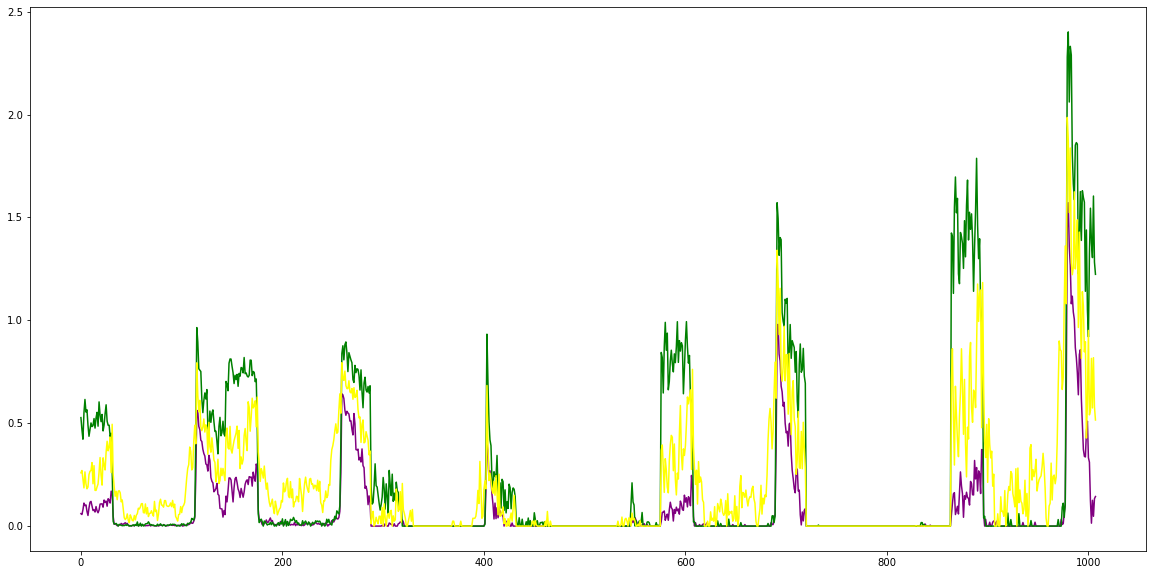

In [19]:
plt.figure(figsize=(20,10))
#plt.plot(act_origs_npy[group_idxs_ == 0].mean(axis=0)) #blue
plt.plot(act_filter[group_idxs_ == 1].mean(axis=0), color='purple')
plt.plot(act_filter[group_idxs_ == 2].mean(axis=0), color='green') #blue
plt.plot(act_filter[group_idxs_ == 3].mean(axis=0), color='yellow') #green
#plt.plot(act_origs_npy[group_idxs_ == 4].mean(axis=0), color='yellow')

### filter gen

In [4]:
filter_gen = (meta_union['Gen'] == 'WT') | (meta_union['Gen'] == 'F1') | (meta_union['Gen'] == 'F2') | (meta_union['Gen'] == 'F20')
#meta_filter_photo = meta_union[filter_photo]
#filter_photo

In [28]:
meta_gen = meta_union[filter_gen]
meta_gen.shape

(361, 28)

In [7]:
act_gen = act_digests_npy[filter_gen]
act_gen.shape

(361, 1008)

In [8]:
# 3D scatter plot
def scatter3d(data3d, color_map=None, azimuth=-74, elevation=54, figsize=(10, 10)):

    fig = plt.figure(figsize=figsize)
    ax = p3.Axes3D(fig)
    ax.view_init(elevation, azimuth)

    if color_map is None:
        ax.scatter(data3d[:,0], data3d[:,1], data3d[:,2],
                    s=30, edgecolor='k')
    else:
        ax.scatter(data3d[:,0], data3d[:,1], data3d[:,2],
                    color=plt.cm.jet(color_map),
                    s=30, edgecolor='k')
    return ax

def stdscaler (X, use_std=True):
    if use_std:
        return StandardScaler().fit_transform(X)
    else:
        return X

In [10]:
reducer = umap.UMAP(n_components=3, metric='cosine', n_neighbors=nn, random_state=5566)
#reducer = PCA(n_components=3, random_state=5566)

# try:
#     pwdists = pairwise_distances(dr)
# except:
#act_digests_npy = np.concatenate(act_digests)
#act_digests_npy_transformed = stdscaler(act_digests_npy, use_std)
#dr = reducer.fit_transform(act_digests_npy_transformed)

act_gen_transformed = stdscaler(act_gen, use_std)
dr = reducer.fit_transform(act_gen_transformed)
act_gen_transformed.shape
dr.shape
# reducer.fit(act_digests_npy_transformed)
# reducer.transform(act_digests_npy_transformed)
pwdists = pairwise_distances(dr)

pwdists.shape

(361, 361)

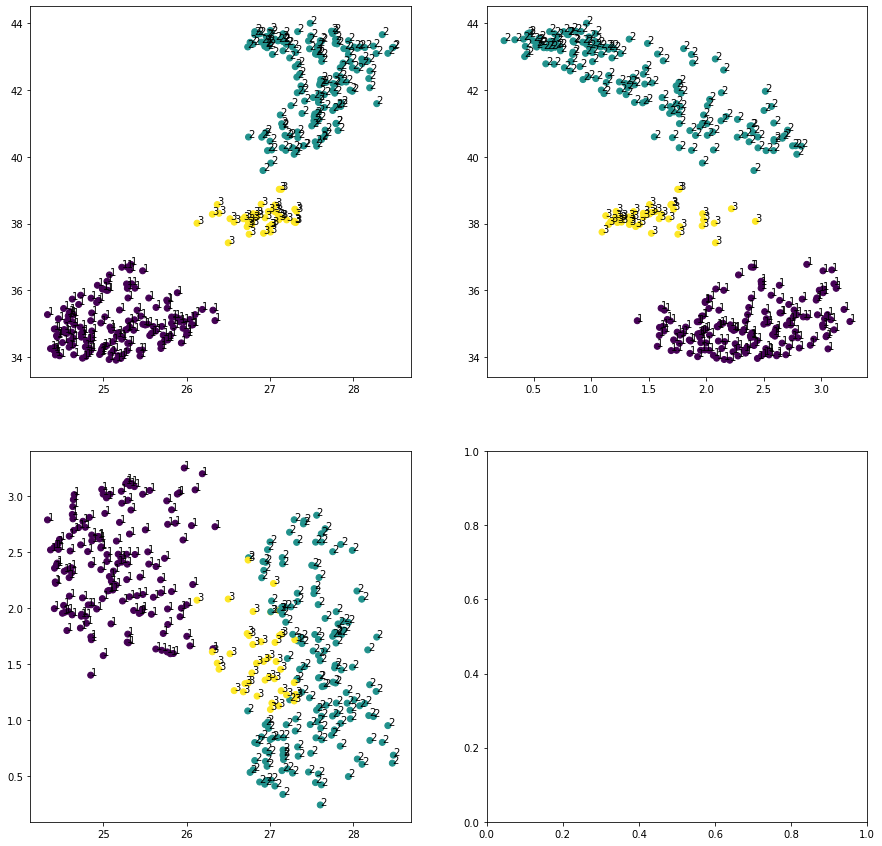

In [25]:
min_samples = 20

shortest_dists_mean = np.take_along_axis(pwdists, np.argsort(pwdists)[:,1:(1+min_samples)], axis=1).mean(axis=1)
shortest_dists_mean_std = shortest_dists_mean.std()
eps = shortest_dists_mean.mean() + 2 * shortest_dists_mean_std

clusterer = DBSCAN(eps=eps, min_samples=min_samples)
group_idxs_ = clusterer.fit_predict(dr) + 1
group_idxs = group_idxs_[group_idxs_ > 0]
dr_wg = dr[group_idxs_ > 0]
gcolor_map = group_idxs / (group_idxs.max() + 1)

fig, axs = plt.subplots(2, 2, figsize=(15, 15))
axs[0][0].scatter(dr_wg[:,0], dr_wg[:,1], c=gcolor_map)
axs[0][1].scatter(dr_wg[:,2], dr_wg[:,1], c=gcolor_map)
axs[1][0].scatter(dr_wg[:,0], dr_wg[:,2], c=gcolor_map)
for tid in range(dr_wg.shape[0]):
    axs[0][0].text(dr_wg[tid,0], dr_wg[tid,1], group_idxs[tid])
    axs[0][1].text(dr_wg[tid,2], dr_wg[tid,1], group_idxs[tid])
    axs[1][0].text(dr_wg[tid,0], dr_wg[tid,2], group_idxs[tid])
plt.show()

In [72]:
meta_filter.shape

(170, 28)

In [19]:
# adding a group column, organizing the scatterplot group 1,2 into data table
meta_gen_with_group = meta_gen.copy()
meta_gen_with_group['group'] = group_idxs_
meta_gen_with_group[group_idxs_ == 2].iloc[:20]
# meta_filter_with_group[group_idxs_ == 0] 
# 2 WL indivs belong to group 0 (outliers)

,ExpID,File_Name,Env,Setup,LD_cycle,Num,ID,Nest,Source,Location,...,End_Date,Soil,Bury,Eggs,Instar,Distance,Carcass,Phenotype,expression,group
1,Loc0924,Monitor20200924_0928_soil,warmroom,soil,LD_4,2,S9498,n7588,WL,1_2,...,10/6/20,10.002,0.0,0.0,0.0,0.637,0.0,s,NaN,2
3,Loc0924,Monitor20200924_0928_soil,warmroom,soil,LD_4,4,S9286,n7578,WL,3_3,...,10/6/20,10.137,0.0,0.0,0.0,1.358,0.0,s,NaN,2
6,Loc0924,Monitor20200924_0928_soil,warmroom,soil,LD_4,7,S9211,n7565,WL,1_1,...,10/6/20,10.091,0.0,0.0,0.0,0.802,0.0,s,NaN,2
7,Loc0924,Monitor20200924_0928_soil,warmroom,soil,LD_4,8,S9461,n7583,WL,1_1,...,10/6/20,10.091,0.0,0.0,0.0,0.923,0.0,s,NaN,2
11,Loc0924,Monitor20200924_0928_soil,warmroom,soil,LD_4,12,S9177,n7584,BF,8_8,...,10/13/20,10.165,1.0,0.0,0.0,0.609,0.0,s,NaN,2
12,Loc0924,Monitor20200924_0928_soil,warmroom,soil,LD_4,13,S9408,n7573,BF,12_10,...,10/13/20,10.239,1.0,0.0,1.0,5.578,0.0,y,NaN,2
14,Loc0924,Monitor20200924_0928_soil,warmroom,soil,LD_4,15,S9260,n7578,WL,3_3,...,10/6/20,10.180,0.0,0.0,0.0,2.865,0.0,s,NaN,2
15,Loc0924,Monitor20200924_0928_soil,warmroom,soil,LD_4,16,S9367,n7577,BF,12_12,...,10/13/20,10.062,0.0,0.0,0.0,2.944,0.0,s,NaN,2
18,Loc0924,Monitor20200924_0928_soil,warmroom,soil,LD_4,19,S9219,n7565,WL,1_1,...,10/6/20,10.208,0.0,0.0,0.0,6.504,0.0,s,NaN,2
19,Loc0924,Monitor20200924_0928_soil,warmroom,soil,LD_4,20,S9450,n7583,WL,1_1,...,10/6/20,10.127,0.0,0.0,0.0,2.376,0.0,s,NaN,2


In [ ]:
plt.figure(figsize=(20,10))
#plt.plot(act_filter[group_idxs_ == 0].mean(axis=0)) #blue
plt.plot(act_gen[group_idxs_ == 1].mean(axis=0)) #orange
plt.plot(act_gen[group_idxs_ == 2].mean(axis=0)) #green
plt.plot(act_gen[group_idxs_ == 3].mean(axis=0)) #red

### stats

In [26]:
from scipy.stats import chisquare
#scipy.stats.chisquare(f_obs, f_exp=None, ddof=0, axis=0)

group_sizes = pd.DataFrame({'gid':group_idxs}).groupby('gid').size().values
# f_exp: array_like, optional 
# (Expected frequencies in each category. By default the categories are assumed to be equally likely.)
f_exp = group_sizes / group_sizes.sum()

# cand_cols = ['Nest', 'Source', 'Elevation', 'Gen', 'Sex', 'Photo', 'Instar']
cand_cols = ['Source']
#cand_cols = ['Sex']
#cand_cols = ['Gen']
# np.array(np.meshgrid(cand_cols, cand_cols)).T.reshape(-1, 2)
biased_chars_all = np.array([])
chi2_all = np.array([])
pvalue_all = np.array([])
char_sample_size_all = np.array([])
cat_col_str_all = np.array([])
for i in range(len(cand_cols)):
    for j in range(i, len(cand_cols)):
        cat_col = list(np.unique([cand_cols[i], cand_cols[j]]))
        
        meta_gen = pd.concat(metas).reset_index(drop=True)
        #meta_union = pd.concat(metas).reset_index(drop=True)
        act_digests_npy = np.concatenate(act_digests)

        cat_col_str = '_x_'.join(cat_col)

        print(cat_col_str)
        meta_gen[cat_col_str] = meta_gen[cat_col].replace(np.nan, 'NaN').astype(str).apply('_x_'.join, axis=1)
        #meta_union[cat_col_str] = meta_union[cat_col].replace(np.nan, 'NaN').astype(str).apply('_x_'.join, axis=1)
        
        char_to_group = pd.DataFrame.from_dict({'gid': group_idxs, 'char': meta_gen[cat_col_str].values[group_idxs_ > 0]}).pivot_table(index='gid', columns='char', aggfunc=len)
        #char_to_group = pd.DataFrame.from_dict({'gid': group_idxs, 'char': meta_union[cat_col_str].values[group_idxs_ > 0]}).pivot_table(index='gid', columns='char', aggfunc=len)
        char_to_group = char_to_group.replace(np.nan, 0)

        f_exp_weighted = char_to_group.sum().values * np.repeat(np.expand_dims(f_exp, axis=0), char_to_group.shape[1], axis=0).T
        # pd.concat([char_to_group.reset_index(), pd.DataFrame(f_exp)], axis=1)
        chi2test = chisquare(char_to_group, f_exp=f_exp_weighted)
        
        # group_sizesT = meta_union[[cat_col_str]].groupby(cat_col_str).size().values
        # f_expT = group_sizesT / group_sizesT.sum()
        # chi2testT = chisquare(char_to_group.T, f_exp=np.repeat(np.expand_dims(f_expT, axis=0), char_to_group.shape[0], axis=0).T)
        # if (chi2testT.pvalue < 1e-4).all():
        #     print(cat_col_str)
        
        pvalue_thres_idxs = (chi2test.pvalue < 0.05)
        biased_chars = char_to_group.columns.values[pvalue_thres_idxs]
        biased_chars_all = np.append(biased_chars_all, biased_chars)
        chi2 = chi2test.statistic[pvalue_thres_idxs]
        chi2_all = np.append(chi2_all, chi2)
        pvalue_all = np.append(pvalue_all, chi2test.pvalue[pvalue_thres_idxs])
        char_sample_size_all = np.append(char_sample_size_all, char_to_group.sum()[pvalue_thres_idxs].values)
        cat_col_str_all = np.append(cat_col_str_all, np.repeat(cat_col_str, chi2.shape[0]))
        print(biased_chars)
        # print([d for d in char_to_group.columns.values if d not in biased_chars])

Source


IndexError: boolean index did not match indexed array along dimension 0; dimension is 512 but corresponding boolean dimension is 361

In [29]:
meta_gen

,ExpID,File_Name,Env,Setup,LD_cycle,Num,ID,Nest,Source,Location,...,Start_Date,End_Date,Soil,Bury,Eggs,Instar,Distance,Carcass,Phenotype,expression
0,Loc0924,Monitor20200924_0928_soil,warmroom,soil,LD_4,1,S9368,n7577,BF,12_12,...,9/30/20,10/13/20,10.504,0.5,0.0,0.0,NaN,NaN,y,NaN
1,Loc0924,Monitor20200924_0928_soil,warmroom,soil,LD_4,2,S9498,n7588,WL,1_2,...,9/30/20,10/6/20,10.002,0.0,0.0,0.0,0.637,0.0,s,NaN
2,Loc0924,Monitor20200924_0928_soil,warmroom,soil,LD_4,3,S9187,n7584,BF,8_8,...,9/30/20,10/13/20,10.504,0.5,0.0,0.0,3.553,0.0,s,NaN
3,Loc0924,Monitor20200924_0928_soil,warmroom,soil,LD_4,4,S9286,n7578,WL,3_3,...,9/30/20,10/6/20,10.137,0.0,0.0,0.0,1.358,0.0,s,NaN
4,Loc0924,Monitor20200924_0928_soil,warmroom,soil,LD_4,5,S9412,n7573,BF,12_10,...,9/30/20,10/13/20,9.960,1.0,1.0,0.0,NaN,NaN,y,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
507,Loc0116-2,Monitor20210116_0120(2)_edit,long,soil,LD_4,28,T2460,n7952,WL,7585_7588,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
508,Loc0116-2,Monitor20210116_0120(2)_edit,long,soil,LD_4,29,T1843,n7942,OK,7600_7529,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
509,Loc0116-2,Monitor20210116_0120(2)_edit,long,soil,LD_4,30,T2577,n7976,WL,S9507_S9277,...,1/26/21,2/2/21,9.754,0.0,0.0,0.0,0.746,0.0,s,NaN
510,Loc0116-2,Monitor20210116_0120(2)_edit,long,soil,LD_4,31,T2112,n7947,WL,7565_7568,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
